In [1]:
import yfinance as a
import os
import pandas as pd
nsfi = a.Ticker('^NSEI')
nsfi_hist = nsfi.history(period = 'max')
data_path = "tcs_ata.json"
if os.path.exists(data_path):
    with open(data_path) as r:
        nsfi_hist = pd.read_json(data_path)
else:
    nsfi =a.Ticker('^NSEI')
    nsfi_hist = nsfi.history(period ='max')

    nsfi_hist.to_json(data_path)
nsfi_hist.head(5)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
2007-09-16 18:30:00,4518.450195,4549.049805,4482.850098,4494.649902,0,0,0
2007-09-17 18:30:00,4494.100098,4551.799805,4481.549805,4546.200195,0,0,0
2007-09-18 18:30:00,4550.250000,4739.000000,4550.250000,4732.350098,0,0,0
2007-09-19 18:30:00,4734.850098,4760.850098,4721.149902,4747.549805,0,0,0
2007-09-20 18:30:00,4752.950195,4855.700195,4733.700195,4837.549805,0,0,0


<Axes: >

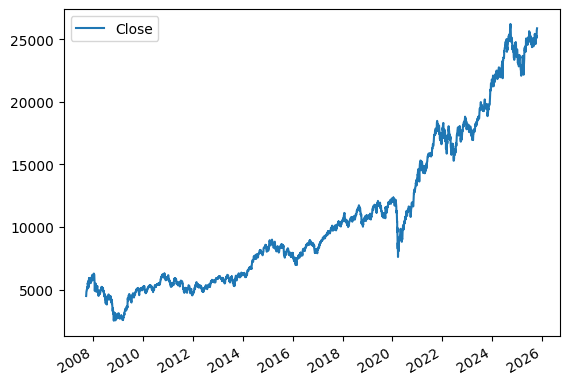

In [2]:
nsfi_hist.plot.line(y="Close", use_index=True)

In [3]:
data = nsfi_hist[['Close']]
data = data.rename(columns = {'Close':'Actual_Close'})
data['Target'] = nsfi_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])['Close']
data.head()

,Actual_Close,Target
2007-09-16 18:30:00,4494.649902,NaN
2007-09-17 18:30:00,4546.200195,1.0
2007-09-18 18:30:00,4732.350098,1.0
2007-09-19 18:30:00,4747.549805,1.0
2007-09-20 18:30:00,4837.549805,1.0


In [4]:
nsfi_pr = nsfi_hist.copy()
nsfi_pr = nsfi_pr.shift(1)
nsfi_pr.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2007-09-16 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-17 18:30:00,4518.450195,4549.049805,4482.850098,4494.649902,0.0,0.0,0.0
2007-09-18 18:30:00,4494.100098,4551.799805,4481.549805,4546.200195,0.0,0.0,0.0
2007-09-19 18:30:00,4550.250000,4739.000000,4550.250000,4732.350098,0.0,0.0,0.0
2007-09-20 18:30:00,4734.850098,4760.850098,4721.149902,4747.549805,0.0,0.0,0.0


In [5]:
predictors = ['Close','Volume','Open','High','Low']
data = data.join(nsfi_pr[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
2007-09-17 18:30:00,4546.200195,1.0,4494.649902,0.0,4518.450195,4549.049805,4482.850098
2007-09-18 18:30:00,4732.350098,1.0,4546.200195,0.0,4494.100098,4551.799805,4481.549805
2007-09-19 18:30:00,4747.549805,1.0,4732.350098,0.0,4550.250000,4739.000000,4550.250000
2007-09-20 18:30:00,4837.549805,1.0,4747.549805,0.0,4734.850098,4760.850098,4721.149902
2007-09-23 18:30:00,4932.200195,1.0,4837.549805,0.0,4752.950195,4855.700195,4733.700195


In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=200, random_state=1)

In [7]:
train = data.iloc[:-100]
test = data.iloc[-100:]
model.fit(train[predictors], train['Target'])

,n_estimators,100
,criterion,'gini'
,max_depth,200
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)
precision_score(test['Target'], preds)

0.5686274509803921

<Axes: >

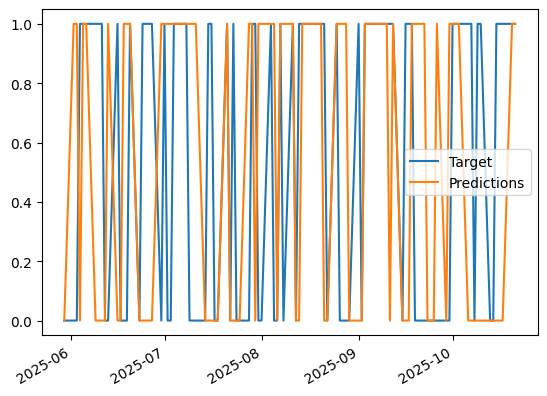

In [9]:
combined = pd.concat({'Target': test['Target'],'Predictions': preds}, axis = 1)
combined.plot()

In [10]:
# backtesting
i = 1000
step = 750
train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train['Target'])
preds = model.predict(test[predictors])

In [9]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index = test.index)
preds[preds > .6] = 1
preds[preds <= .6] = 0

In [10]:
preds.head()

2025-05-29 18:30:00    0.0
2025-06-01 18:30:00    1.0
2025-06-02 18:30:00    1.0
2025-06-03 18:30:00    0.0
2025-06-04 18:30:00    1.0
dtype: float64

In [37]:
predictions = []
for i in range(1000, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index = test.index)
    preds[preds > .6] = 1
    preds[preds<= .6] = 0

    combined = pd.concat({'Target': test['Target'], 'predictions': preds}, axis =1)
    predictions.append(combined)

In [14]:
predictions[0].head()

,Target,predictions
2011-10-13 18:30:00,1.0,0.0
2011-10-16 18:30:00,0.0,0.0
2011-10-17 18:30:00,0.0,0.0
2011-10-18 18:30:00,1.0,0.0
2011-10-19 18:30:00,0.0,0.0


In [15]:
def backtest(data,model, predictors, start = 1000, step = 750):
    predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        model.fit(train[predictors], train['Target'])

        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index = test.index)
        preds[preds >.6] = 1
        preds[preds <= .6] = 0
        combined = pd.concat({'Target': test['Target'], 'predictions': preds}, axis = 1)
        predictions.append(combined)
    return pd.concat(predictions)

In [16]:
predictions = backtest(data, model, predictors)

In [17]:
predictions['predictions'].value_counts()

predictions
0.0    3066
1.0     372
Name: count, dtype: int64

In [18]:
predictions['Target'].value_counts()

Target
1.0    1849
0.0    1589
Name: count, dtype: int64

In [19]:
precision_score(predictions['Target'], predictions['predictions'])

0.532258064516129

In [20]:
# for increase accuracy we add roling means

In [21]:
weekly_mean = data.rolling(7).mean()['Close']
quarterly_mean = data.rolling(90).mean()['Close']
annual_mean = data.rolling(365).mean()['Close']

In [22]:
weekly_trend = data.shift(1).rolling(7).sum()['Target']

In [23]:
data['weekly_mean'] = weekly_mean/data['Close']
data['quarterly_mean'] = quarterly_mean/data['Close']
data['annual_mean'] = annual_mean/data['Close']

In [24]:
data['annual_weekly_mean'] = data['annual_mean']/data['weekly_mean']
data['annual_quarterly_mean'] = data['annual_mean']/data['quarterly_mean']

In [25]:
data['weekly_trend'] = weekly_trend

In [26]:
data['Open_Close_ratio'] = data['Open']/data['Close']
data['High_Close_ratio'] = data['High']/data['Close']
data['Low_Close_ratio'] = data['Low']/data['Close']

In [32]:
full_predictors = predictors + ['weekly_mean','quarterly_mean','annual_weekly_mean','Open_Close_ratio', "High_Close_ratio","Low_Close_ratio"]

In [33]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [34]:
precision_score(predictions['Target'], predictions['predictions'])

0.5815602836879432

In [35]:
predictions['predictions'].value_counts()

predictions
0.0    2932
1.0     141
Name: count, dtype: int64

<Axes: >

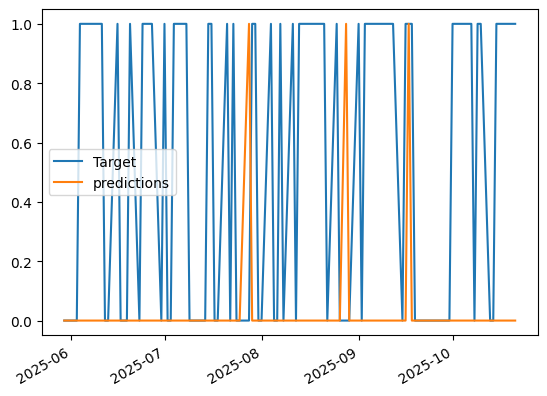

In [36]:
predictions.iloc[-100:].plot()